# 1. Data Analysis and Preparation

## 1.1 Load and Summarize Data
- Load `Country-data.csv` into a pandas DataFrame.
- Print the header using `DataFrame.head()`.
- Use `DataFrame.describe()` to summarize the dataset.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
url = "https://raw.githubusercontent.com/Hunteracademic/Unsupervised_assignment_1/master/Country-data.csv"
country_data = pd.read_csv(url)
country_data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [22]:
country_data.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000



#### Add some insights from describe
There are 9 different columns with numerical data that descriptive statistics can use. 

Notable there are 167 different counties in this dataset that represent each row. 


- Explain the meaning of each column.
- Make observations based on the summary statistics.
- Discuss whether these statistics provide useful insights.


## 1.2 Data Integrity and Cleaning
- Use `DataFrame.info()` to check data types and missing values.
- Use `DataFrame.duplicated()` to identify duplicate entries.
- Clean the dataset:
  - Remove missing values.
  - Drop duplicate rows.
  - Correct any incorrect data types.
- Document the cleaning process and changes in Markdown.


In [23]:
country_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [24]:
print(country_data.duplicated().sum())

0


In [3]:
print(country_data.isna().sum())

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64


 Initial exploration did not show any null or duplicate values

#### Data Cleaning Process
- 
- 
- 

*Might not need insights for this part as there is no cleaning needed*

## 1.3 Feature Correlation and Visualization
- Drop the `country` column and store it separately.
- Use `seaborn.heatmap()` to display the correlation matrix.
- Use `seaborn.pairplot()` to generate scatter plots and histograms.
- Record observations in Markdown:
  - Discuss insights gained from the visualizations.


In [5]:
No_country_data = country_data.drop("country", axis=1)
country = country_data["country"]
No_country_data.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [6]:
country

0                         Afghanistan
1                             Albania
2                             Algeria
3                              Angola
4                 Antigua and Barbuda
5                           Argentina
6                             Armenia
7                           Australia
8                             Austria
9                          Azerbaijan
10                            Bahamas
11                            Bahrain
12                         Bangladesh
13                           Barbados
14                            Belarus
15                            Belgium
16                             Belize
17                              Benin
18                             Bhutan
19                            Bolivia
20             Bosnia and Herzegovina
21                           Botswana
22                             Brazil
23                             Brunei
24                           Bulgaria
25                       Burkina Faso
26          

Text(0.5, 1, 'Correlation Heatmap of Country Data')

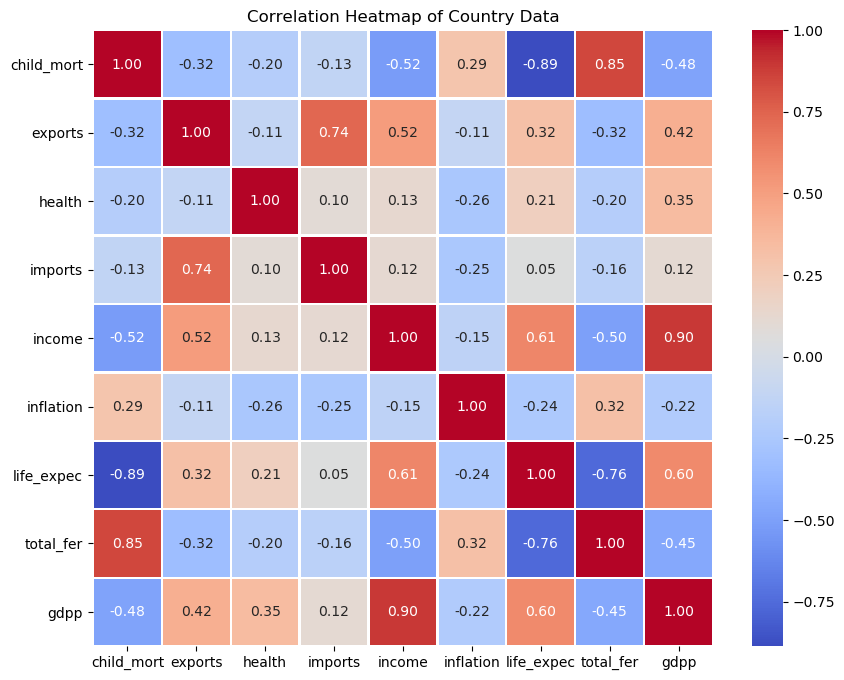

In [7]:
corr = No_country_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=1
)
plt.title("Correlation Heatmap of Country Data")

#### Insights from Correlation Heatmap
- 
- 
- 

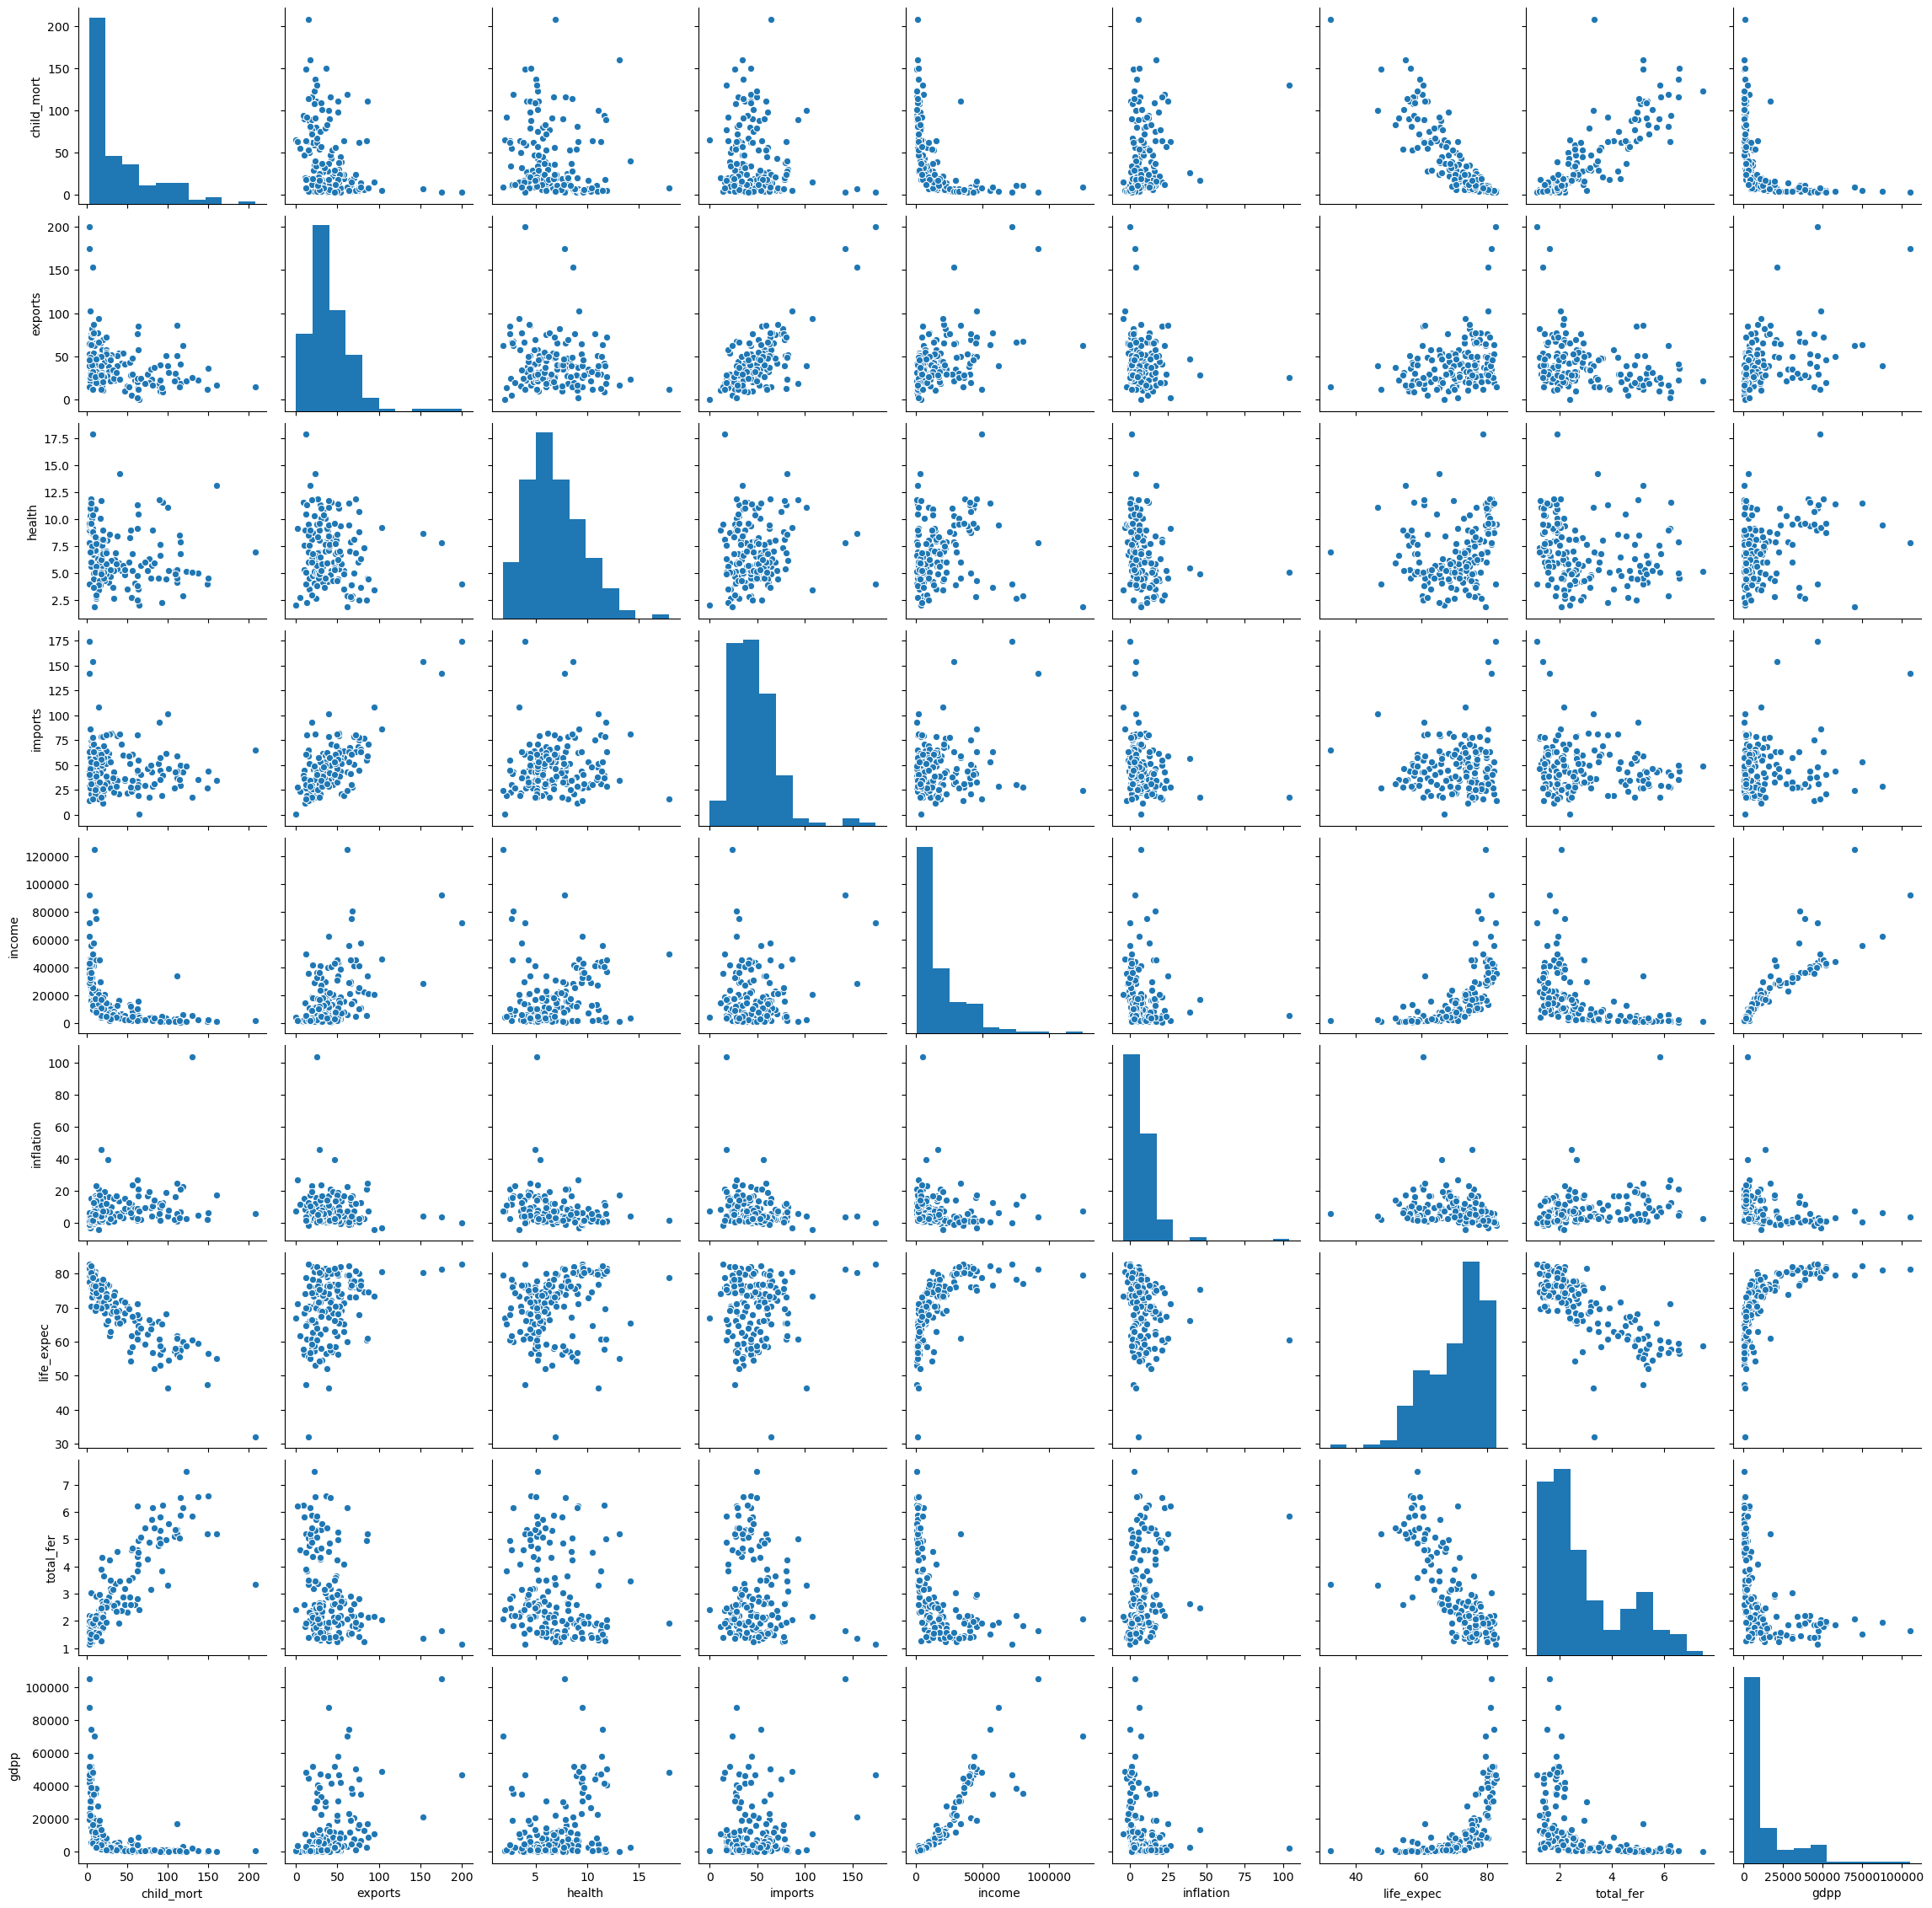

In [8]:
sns.pairplot(No_country_data)

# g = sns.pairplot(No_country_data, diag_kind="kde")
# g.map_lower(sns.kdeplot, levels=4, color=".2")

# The pairplot that she gave us outputs a ton of info. 
### After this visual we have more specific graphs for insights on high or low correlated features.
##### *change the hashtag to see a different set of the pairplot*
##### *adjust as you feel necessary*

### Pairplot Insights
- 
- 
- 


# 2. Clustering and Modeling

## 2.1 Data Scaling
- Use `sklearn.preprocessing.StandardScaler` to scale the data.
- Print the transformed header.



## 2.2 KMeans Clustering and Evaluation
- Use `sklearn.cluster.KMeans` to cluster the data.
- Try `n_clusters` values in the range [2, 10].
- Calculate the silhouette score for each value.
- Plot silhouette score vs. number of clusters.



## 2.3 Model Selection and Justification
- Choose the best model based on silhouette scores and other criteria.
- Justify the selected number of clusters in Markdown.
- Save the corresponding model as the best model.
- Note: Silhouette score is a guide, not an absolute metric.



# 3. Interpretation and Allocation Strategy

## 3.1 Cluster Visualization
- Choose a pair of columns from step 1.
- Generate a scatter plot colored by cluster assignment.
- Comment on the plot in Markdown.



## 3.2 Cluster Size Distribution
- Generate a histogram showing the number of countries in each cluster.
- Provide observations in Markdown:
  - Discuss whether the cluster sizes make sense.



## 3.3 Cluster Composition and Ranking
- Print the country names in each cluster.
- Comment on the logical coherence of the results.
- Rank clusters from most aid-needed to least.
- Use quick research to verify alignment with real-world conditions.
- Summarize findings in Markdown.



## 3.4 Fund Allocation Strategy
- Describe which countries will receive funds.
- Specify how much each country will receive.
- Justify the allocation strategy.

# Below are more graphs for visualization, they are reiterating the pairplot graph 

# *Do we need these?*

### Insights
- 
- 
- 



In [28]:
def scatterPlot(df, xColumn: str, yColumn: str, ax):
    '''
    Scatterplot
    '''
    scatterplot = df.plot.scatter(
        x= xColumn, y= yColumn,
        colormap='inferno', ax=ax, figsize=(18, 6)
    )
    ax.tick_params(axis='x')
    ax.set_title(f"{xColumn} and {yColumn}")
    return scatterplot



The following are the highest correlating columns based on the heat map. 
 Highest to lowest:



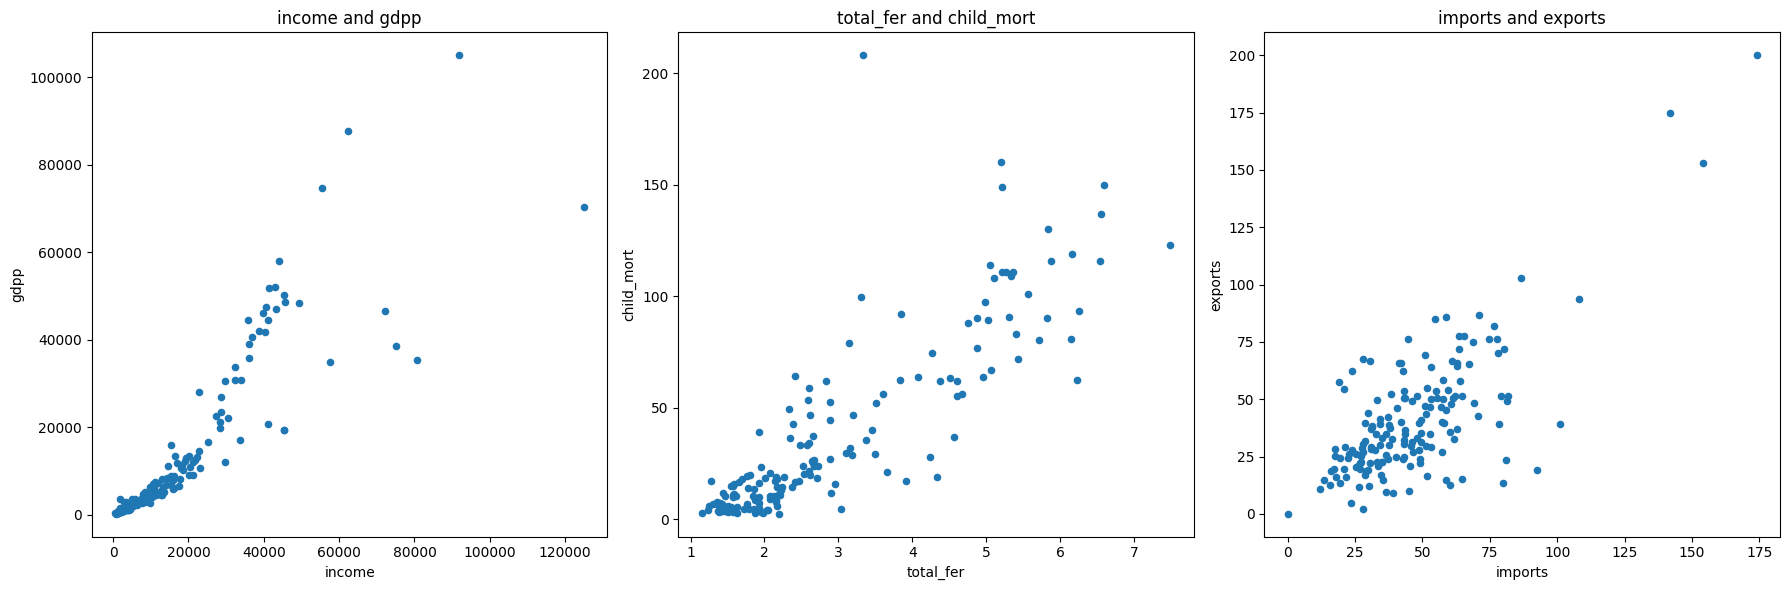

The following are the lowest correlating columns based on the heat map. 
Lowest to highest:



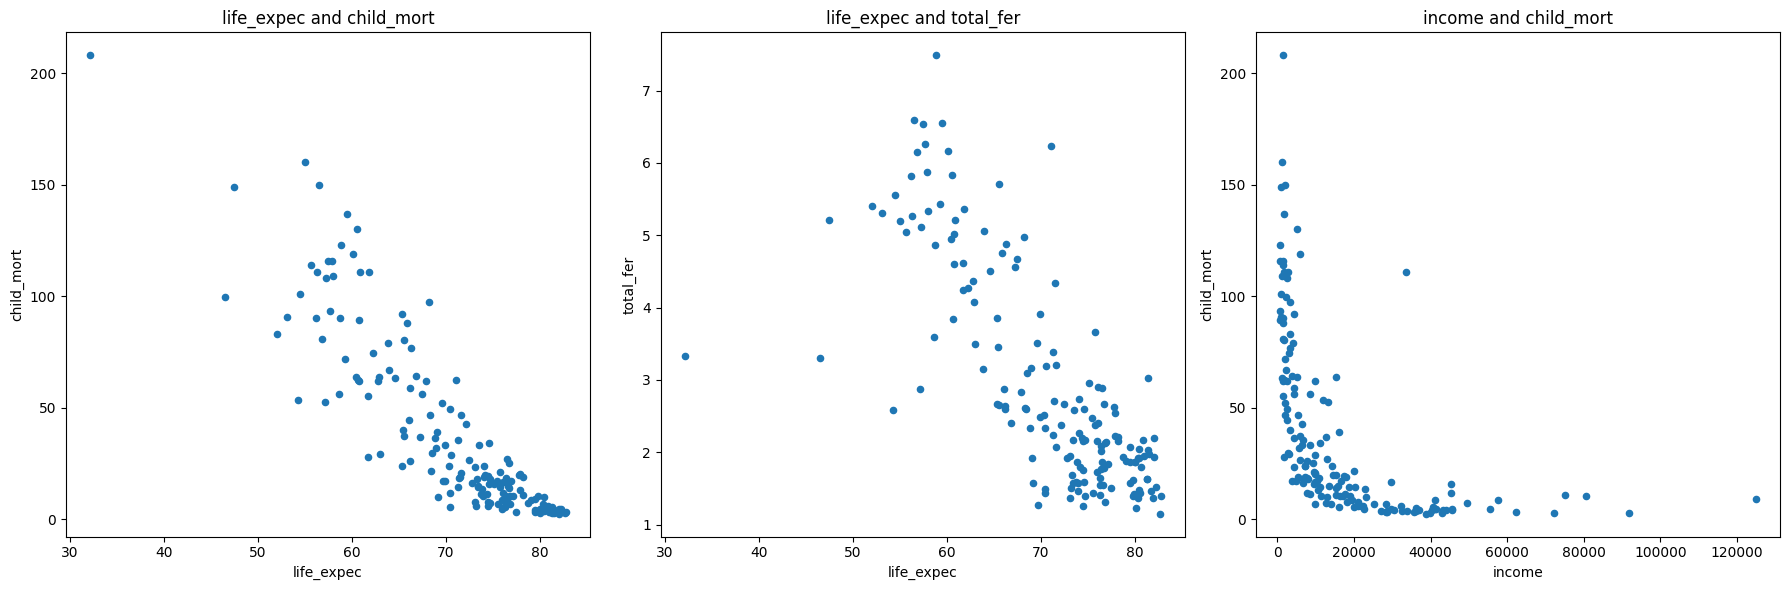

In [29]:
print("The following are the highest correlating columns based on the heat map. \n Highest to lowest:\n")

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(22, 6))

scatterPlot(No_country_data, 'income', 'gdpp',  axes[0])
scatterPlot(No_country_data, 'total_fer', 'child_mort',  axes[1])
scatterPlot(No_country_data, 'imports', 'exports', axes[2])

plt.tight_layout()
plt.show()

print("The following are the lowest correlating columns based on the heat map. \nLowest to highest:\n")

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(22, 6))

scatterPlot(No_country_data, 'life_expec', 'child_mort',  axes[0])
scatterPlot(No_country_data, 'life_expec', 'total_fer',  axes[1])
scatterPlot(No_country_data, 'income', 'child_mort', axes[2])

plt.tight_layout()
plt.show()

In [55]:
def histogram(df, column, bin_s, ax):
    sns.histplot(
        data=df,
        x=column,
        bins= bin_s,
        kde=True,
        ax=axes[ax]
    )
    axes[ax].set_title(f"Distribution of {column}")
    axes[ax].set_xlabel(f"{column}")
    axes[ax].set_ylabel("Count of countries")


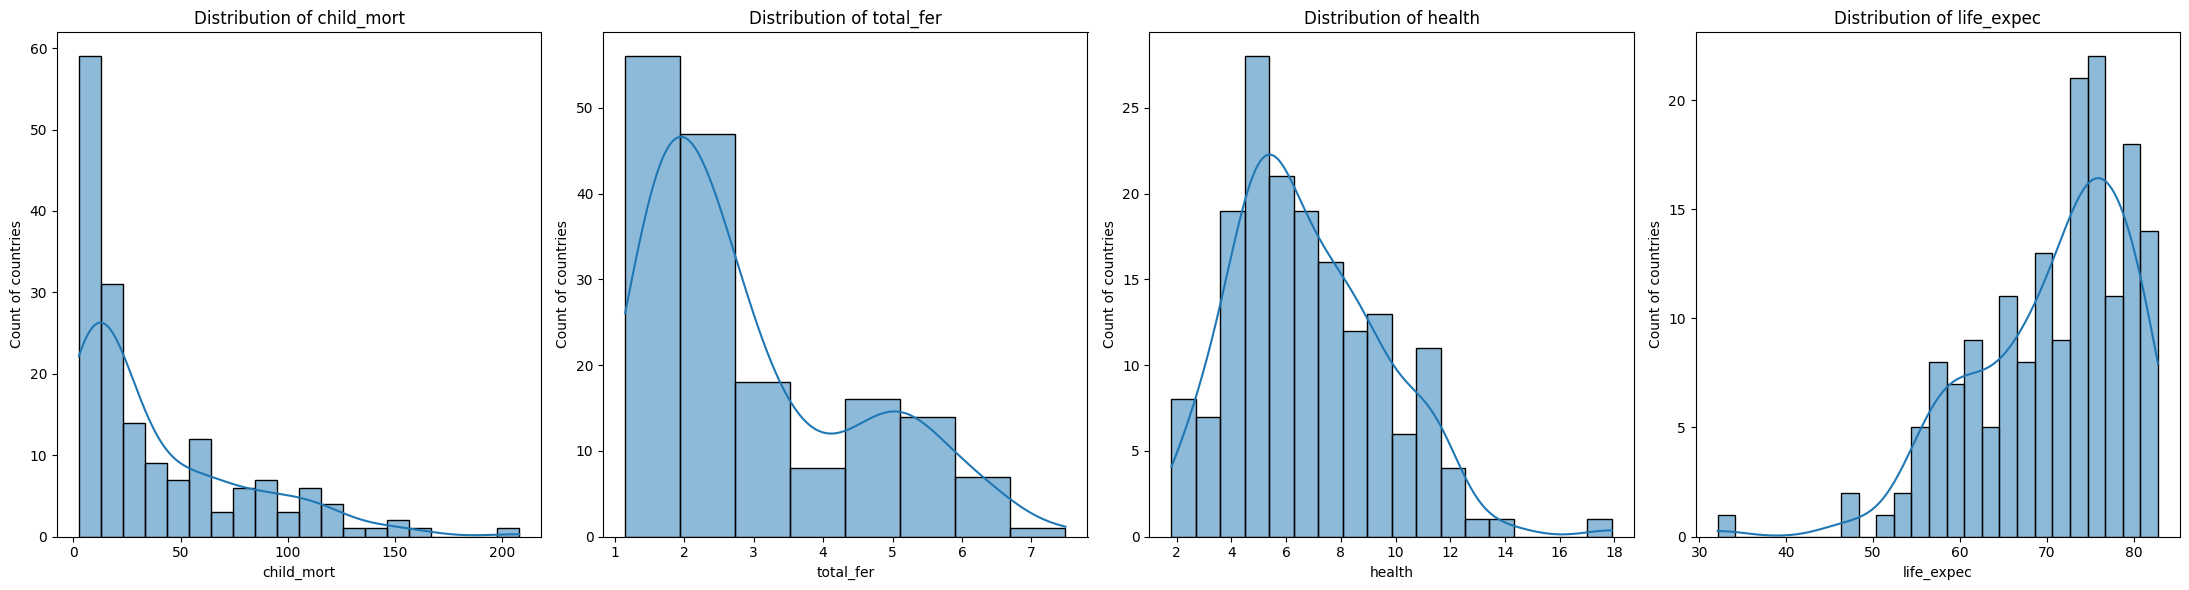

In [56]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(22, 6))

histogram(No_country_data, "child_mort", 20,  0)
histogram(No_country_data, "total_fer", 8, 1)
histogram(No_country_data, "health", 18, 2)
histogram(No_country_data, "life_expec",25, 3)

plt.tight_layout()
plt.show()